<a href="https://www.kaggle.com/code/vishorita/model-building-using-automl?scriptVersionId=121418582" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:

import h2o
from h2o.automl import H2OAutoML


from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import warnings
warnings.filterwarnings("ignore")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/credit-card-customer-churn-prediction/Churn_Modelling.csv


In [2]:
h2o.init(max_mem_size="16G")

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.17" 2022-10-18; OpenJDK Runtime Environment (build 11.0.17+8-post-Ubuntu-1ubuntu220.04); OpenJDK 64-Bit Server VM (build 11.0.17+8-post-Ubuntu-1ubuntu220.04, mixed mode, sharing)
  Starting server from /opt/conda/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmppns7j3xa
  JVM stdout: /tmp/tmppns7j3xa/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmppns7j3xa/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.1
H2O_cluster_version_age:,27 days
H2O_cluster_name:,H2O_from_python_unknownUser_aveou8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,16 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


In [3]:
df = h2o.import_file('/kaggle/input/credit-card-customer-churn-prediction/Churn_Modelling.csv')

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [4]:
df.head()

RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
1,1.56346e+07,Hargrave,619,France,Female,42,2,0,1,1,1,101349,1
2,1.56473e+07,Hill,608,Spain,Female,41,1,83807.9,1,0,1,112543,0
3,1.56193e+07,Onio,502,France,Female,42,8,159661,3,1,0,113932,1
4,1.57014e+07,Boni,699,France,Female,39,1,0,2,0,0,93826.6,0
5,1.57379e+07,Mitchell,850,Spain,Female,43,2,125511,1,1,1,79084.1,0
6,1.5574e+07,Chu,645,Spain,Male,44,8,113756,2,1,0,149757,1
7,1.55925e+07,Bartlett,822,France,Male,50,7,0,2,1,1,10062.8,0
8,1.56561e+07,Obinna,376,Germany,Female,29,4,115047,4,1,0,119347,1
9,1.57924e+07,He,501,France,Male,44,4,142051,2,0,1,74940.5,0
10,1.55924e+07,H?,684,France,Male,27,2,134604,1,1,1,71725.7,0


In [5]:
df_train, df_test = df.split_frame(ratios=[.8])

In [6]:
df_train

RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
1,1.56346e+07,Hargrave,619,France,Female,42,2,0,1,1,1,101349,1
2,1.56473e+07,Hill,608,Spain,Female,41,1,83807.9,1,0,1,112543,0
3,1.56193e+07,Onio,502,France,Female,42,8,159661,3,1,0,113932,1
4,1.57014e+07,Boni,699,France,Female,39,1,0,2,0,0,93826.6,0
5,1.57379e+07,Mitchell,850,Spain,Female,43,2,125511,1,1,1,79084.1,0
6,1.5574e+07,Chu,645,Spain,Male,44,8,113756,2,1,0,149757,1
7,1.55925e+07,Bartlett,822,France,Male,50,7,0,2,1,1,10062.8,0
8,1.56561e+07,Obinna,376,Germany,Female,29,4,115047,4,1,0,119347,1
9,1.57924e+07,He,501,France,Male,44,4,142051,2,0,1,74940.5,0
10,1.55924e+07,H?,684,France,Male,27,2,134604,1,1,1,71725.7,0


In [7]:
y = 'Exited'
x = df.columns
x.remove(y)
x.remove("CustomerId")
x.remove("Surname")
x.remove("RowNumber")

In [8]:
aml = H2OAutoML(max_runtime_secs=300,max_models=10,seed=10,verbosity='info',nfolds=0)

In [9]:
aml.train(x=x,y=y, training_frame=df_train)

AutoML progress: |
07:48:45.70: Project: AutoML_1_20230308_74845
07:48:45.72: Cross-validation disabled by user: no fold column nor nfolds > 1.
07:48:45.72: Setting stopping tolerance adaptively based on the training frame: 0.011142104507747925
07:48:45.72: Build control seed: 10
07:48:45.80: Since cross-validation is disabled, and validation frame(s) were not provided, automatically split the training data into training, validation frame(s) in the ratio 90/10/0.
07:48:45.146: training frame: Frame key: AutoML_1_20230308_74845_training_py_3_sid_b8dd    cols: 14    rows: 7269  chunks: 16    size: 492684  checksum: 4616894692542138647
07:48:45.154: validation frame: Frame key: AutoML_1_20230308_74845_validation_py_3_sid_b8dd    cols: 14    rows: 786  chunks: 16    size: 294966  checksum: 2677834766997764755
07:48:45.154: leaderboard frame: Frame key: AutoML_1_20230308_74845_validation_py_3_sid_b8dd    cols: 14    rows: 786  chunks: 16    size: 294966  checksum: 2677834766997764755
07:48:

,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
,50.0,50.0,38259.0,7.0,7.0,7.0,24.0,106.0,56.22
,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
,2023-03-08 07:48:53,0.003 sec,0.0,0.4031835,0.3251138,0.1625569,0.4054412,0.3269395,0.1643826
,2023-03-08 07:48:54,0.146 sec,5.0,0.3460622,0.2727258,0.1197591,0.3590083,0.2822770,0.1288870
,2023-03-08 07:48:54,0.295 sec,10.0,0.3188279,0.2407240,0.1016513,0.3414251,0.2566867,0.1165711
,2023-03-08 07:48:54,0.394 sec,15.0,0.3053461,0.2212553,0.0932362,0.3335566,0.2415235,0.1112600
,2023-03-08 07:48:54,0.483 sec,20.0,0.2968818,0.2062644,0.0881388,0.3300683,0.2300300,0.1089451
,2023-03-08 07:48:54,0.607 sec,25.0,0.2908915,0.1965138,0.0846179,0.3277711,0.2222733,0.1074339
,2023-03-08 07:48:54,0.689 sec,30.0,0.2874181,0.1896256,0.0826092,0.3271225,0.2172226,0.1070091
,2023-03-08 07:48:54,0.796 sec,35.0,0.2847272,0.1859788,0.0810696,0.3266104,0.2150132,0.1066744


In [10]:
lb = aml.leaderboard

In [11]:
lb

model_id,rmse,mse,mae,rmsle,mean_residual_deviance
GBM_2_AutoML_1_20230308_74845,0.326168,0.106386,0.210757,0.228378,0.106386
XGBoost_3_AutoML_1_20230308_74845,0.329454,0.10854,0.217013,0.232553,0.10854
GBM_3_AutoML_1_20230308_74845,0.329548,0.108602,0.21317,0.231256,0.108602
GBM_1_AutoML_1_20230308_74845,0.331064,0.109603,0.217431,0.233018,0.109603
GBM_4_AutoML_1_20230308_74845,0.334763,0.112066,0.217148,0.235515,0.112066
DRF_1_AutoML_1_20230308_74845,0.336348,0.11313,0.219274,0.237545,0.11313
XRT_1_AutoML_1_20230308_74845,0.343704,0.118133,0.250303,0.244781,0.118133
XGBoost_2_AutoML_1_20230308_74845,0.35707,0.127499,0.242636,0.25661,0.127499
XGBoost_1_AutoML_1_20230308_74845,0.368415,0.13573,0.255081,0.267577,0.13573
GLM_1_AutoML_1_20230308_74845,0.376304,0.141605,0.28863,0.265037,0.141605


In [12]:
model_ids = list(aml.leaderboard['model_id'].as_data_frame().iloc[:,0])

In [13]:
model_ids

['GBM_2_AutoML_1_20230308_74845',
 'XGBoost_3_AutoML_1_20230308_74845',
 'GBM_3_AutoML_1_20230308_74845',
 'GBM_1_AutoML_1_20230308_74845',
 'GBM_4_AutoML_1_20230308_74845',
 'DRF_1_AutoML_1_20230308_74845',
 'XRT_1_AutoML_1_20230308_74845',
 'XGBoost_2_AutoML_1_20230308_74845',
 'XGBoost_1_AutoML_1_20230308_74845',
 'GLM_1_AutoML_1_20230308_74845']

In [14]:
aml.leader.model_performance(df_test)

ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 0.10455686557720564
RMSE: 0.3233525407000935
MAE: 0.2061277659100876
RMSLE: 0.2276183542611159
Mean Residual Deviance: 0.10455686557720564

In [15]:
h2o.get_model([mid for mid in model_ids if "GBM_2" in mid][0])

,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
,50.0,50.0,38259.0,7.0,7.0,7.0,24.0,106.0,56.22
,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
,2023-03-08 07:48:53,0.003 sec,0.0,0.4031835,0.3251138,0.1625569,0.4054412,0.3269395,0.1643826
,2023-03-08 07:48:54,0.146 sec,5.0,0.3460622,0.2727258,0.1197591,0.3590083,0.2822770,0.1288870
,2023-03-08 07:48:54,0.295 sec,10.0,0.3188279,0.2407240,0.1016513,0.3414251,0.2566867,0.1165711
,2023-03-08 07:48:54,0.394 sec,15.0,0.3053461,0.2212553,0.0932362,0.3335566,0.2415235,0.1112600
,2023-03-08 07:48:54,0.483 sec,20.0,0.2968818,0.2062644,0.0881388,0.3300683,0.2300300,0.1089451
,2023-03-08 07:48:54,0.607 sec,25.0,0.2908915,0.1965138,0.0846179,0.3277711,0.2222733,0.1074339
,2023-03-08 07:48:54,0.689 sec,30.0,0.2874181,0.1896256,0.0826092,0.3271225,0.2172226,0.1070091
,2023-03-08 07:48:54,0.796 sec,35.0,0.2847272,0.1859788,0.0810696,0.3266104,0.2150132,0.1066744


In [16]:
output = h2o.get_model([mid for mid in model_ids if "GBM_2" in mid][0])
output.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'GBM_2_AutoML_1_20230308_74845',
   'type': 'Key<Model>',
   'URL': '/3/Models/GBM_2_AutoML_1_20230308_74845'},
  'input': None},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'AutoML_1_20230308_74845_training_py_3_sid_b8dd',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/AutoML_1_20230308_74845_training_py_3_sid_b8dd'},
  'input': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'AutoML_1_20230308_74845_training_py_3_sid_b8dd',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/AutoML_1_20230308_74845_training_py_3_sid_b8dd'}},
 'validation_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<

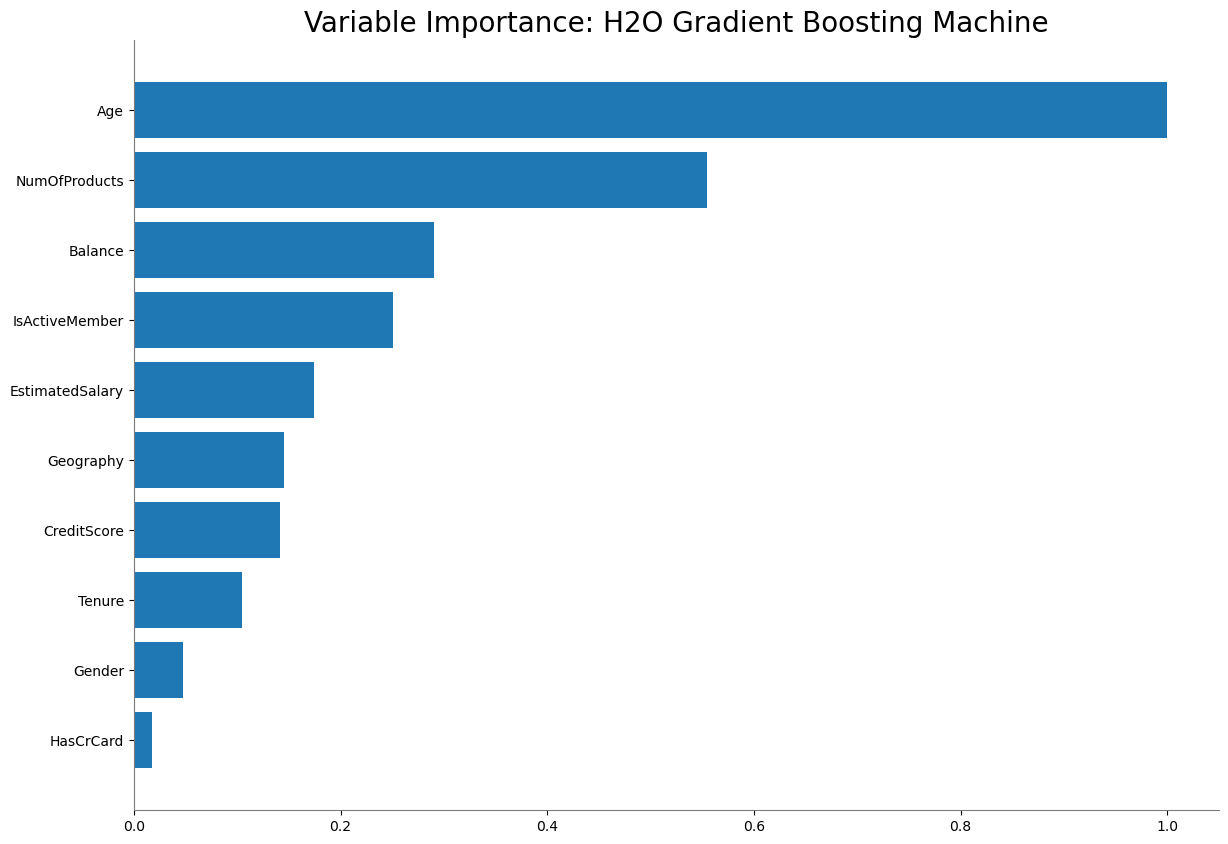

<Figure size 640x480 with 0 Axes>

In [17]:
output.varimp_plot()

In [18]:
aml.leader

,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
,50.0,50.0,38259.0,7.0,7.0,7.0,24.0,106.0,56.22
,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
,2023-03-08 07:48:53,0.003 sec,0.0,0.4031835,0.3251138,0.1625569,0.4054412,0.3269395,0.1643826
,2023-03-08 07:48:54,0.146 sec,5.0,0.3460622,0.2727258,0.1197591,0.3590083,0.2822770,0.1288870
,2023-03-08 07:48:54,0.295 sec,10.0,0.3188279,0.2407240,0.1016513,0.3414251,0.2566867,0.1165711
,2023-03-08 07:48:54,0.394 sec,15.0,0.3053461,0.2212553,0.0932362,0.3335566,0.2415235,0.1112600
,2023-03-08 07:48:54,0.483 sec,20.0,0.2968818,0.2062644,0.0881388,0.3300683,0.2300300,0.1089451
,2023-03-08 07:48:54,0.607 sec,25.0,0.2908915,0.1965138,0.0846179,0.3277711,0.2222733,0.1074339
,2023-03-08 07:48:54,0.689 sec,30.0,0.2874181,0.1896256,0.0826092,0.3271225,0.2172226,0.1070091
,2023-03-08 07:48:54,0.796 sec,35.0,0.2847272,0.1859788,0.0810696,0.3266104,0.2150132,0.1066744


In [19]:
y_pred = aml.leader.predict(df_test)

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


In [20]:
y_pred

predict
0.0314982
0.0787867
0.11427
0.0525488
0.769584
0.123533
0.186987
0.40835
0.4907
0.325718
